# import packages

In [1]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

# function:  plot from yolo_result


In [2]:

def plot_yolo_results(results: 'ultralytics.YOLOResult', image: np.ndarray, plot_setting: dict) -> None:
    """
    Plots the YOLO detection results on an input image with customizable settings.

    Args:
        result (dict): The detection results from the YOLO model, typically containing bounding boxes, class labels, and confidence scores.
        image (np.ndarray): The input image in OpenCV format (a NumPy array) on which the results will be plotted.
        plot_setting (dict): A dictionary containing plot settings such as colors, line thickness, and display options.

    Returns:
        None: The function displays the image with detected objects overlaid according to the specified plot settings. No value is returned.

    Notes:
        Ensure that the `result` dictionary is correctly formatted and matches the output of the YOLO model. Verify that `plot_setting` includes valid configuration parameters for visualization.
    """
    # 定義文本參數
    plot_image=image.copy()

    font_face = plot_setting['font_face']  # Font type
    font_scale = plot_setting['font_scale']  # Font size
    thickness = plot_setting['thickness']  # Text thickness
    line_type = plot_setting['line_type']  # Line type
    color_dict= plot_setting['color_dict']



    # 處理結果
    for result in results:
        # 獲取類別名稱
        class_names = result.names
        class_name_list=[]        
        boxes = result.boxes  # Boxes object for bbox outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        
        if masks is not None:
            for mask, box in zip(masks.data, boxes):
                # Get class ID and confidence
                class_id = int(box.cls)
                #confidence = float(box.conf)
                
                # Get class name
                class_name = class_names[class_id]

                # Convert mask to numpy array and resize to match original image
                mask_np = mask.cpu().numpy()
                mask_np = cv2.resize(mask_np, (image.shape[1], image.shape[0]))
                
                # Convert mask to binary image
                mask_binary = (mask_np > 0.5).astype(np.uint8) * 255
                
                # Check if the mask is valid
                if np.sum(mask_binary) == 0:
                    continue
                
                # Apply mask to the original image
                mask_colored = np.zeros((mask_binary.shape[0], mask_binary.shape[1], 3), dtype=np.uint8)

                if class_name != 'Background':# background label is no needing
                    mask_colored[mask_binary == 255] = color_dict[str(class_id)]
                    
                    # Overlay the colored mask
                    plot_image = cv2.addWeighted(plot_image, 1, mask_colored, 0.8, 0)
                    
                    # Calculate the average color of the masked area
                    map_color = (plot_image[mask_binary == 255].sum(axis=0) / plot_image[mask_binary == 255].shape[0]).astype(np.uint8).tolist()
                    
                    # Add class name to the list if not already present
                    if class_name not in class_name_list:
                        class_name_list.append(class_name)
                        
                        # Draw class name on the image
                        text_position = (mask_binary.shape[0] // 20, mask_binary.shape[1] // 10 * (len(class_name_list)))
                        cv2.putText(plot_image, class_name, text_position, font_face, font_scale, map_color, thickness, line_type)
            plt.imshow(plot_image)
            plt.show()

# Loading the image and inference with API


0: 480x640 1 Alveolar_bone, 1 Caries, 1 Dentin, 1 Enamel, 1 Pulp, 1 Restoration, 1 Background, 47.9ms
Speed: 0.0ms preprocess, 47.9ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


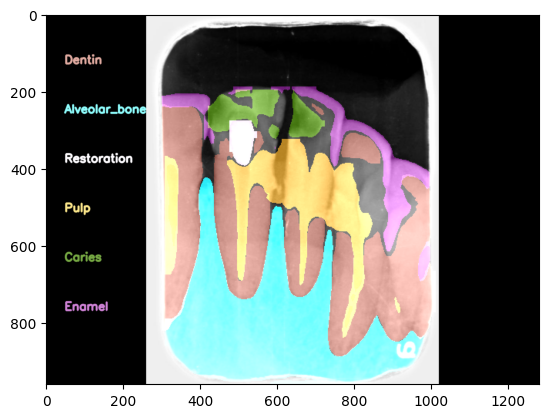

In [9]:
image_path='../data/pics/caries-0.6741573-260-760_1_2022052768.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model = YOLO('../dentistry_yolov8n_20240807_all.pt')

results=model.predict(image,iou=0.1,conf=0.5)
result=results[0]

with open('../conf/mask_color_setting.json', 'r') as file:
    color_dict = json.load(file)
plot_setting={
    'color_dict':color_dict,
    'font_face':cv2.FONT_HERSHEY_SIMPLEX,
    'font_scale':1,
    'thickness':3,
    'line_type':cv2.LINE_AA,
}

plot_yolo_results(results, image, plot_setting)